### Package Declarations

In [3]:
### Package Declarations

# classical
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import math
from itertools import product
from scipy.special import binom, lambertw
from scipy.stats import unitary_group
import pickle

# quantum
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import StabilizerState, Clifford, Statevector, Pauli, random_clifford
from qiskit.visualization import circuit_drawer
from qiskit.circuit import Parameter, ParameterVector, Gate
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.random import random_circuit

### Function Declarations

In [5]:
### Preliminary Functions

# generates the circuit diagram
def Diagram(circuit):
    return circuit_drawer(circuit, output="mpl")

# takes a qiskit QuantumCircuit object as an input and converts it into a numpy array
def Unitary(circuit):
    return np.array(qiskit.quantum_info.Operator(circuit))

# Naive implementation of the quantum cost function as an exponential quadratic form
def NaiveQuantumExpectation(unitary, observable):
    N = int(np.log2(len(unitary)))
    zero_state = np.eye(int(2**N))[0]
    return np.real(np.vdot(unitary @ zero_state, observable @ unitary @ zero_state))

# converts a Pauli-string (e.g. of the form 'IZXYX') to the corresponding unitary operator
def PauliStringUnitary(pauli_string):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    pauli_map = {'I': I, 'X': X, 'Y': Y, 'Z': Z}

    unitary = np.array([[1]])
    for char in pauli_string:
        unitary = np.kron(unitary, pauli_map[char])
    return unitary

# Stabilizer implementation of the quantum expectation (takes a StabilizerState object and a Pauli-string as an observable as inputs)
def StabilizerQuantumExpectation(stabilizer_state, pauli_string):
    return stabilizer_state.expectation_value(Pauli(pauli_string))

### Implementing Observables and Clifford conjugation tools

# returns a random non-trivial Pauli-string of the form 'IZXYZX' of length N
def RandomPauliString(N):
    pauli_chars = ['I', 'X', 'Y', 'Z']
    Pauli_string = ''.join(random.choice(pauli_chars) for _ in range(N))
    if Pauli_string == N * 'I':
        return RandomPauliString(N)
    return Pauli_string

# returns a list of random, non-trivial, unsigned N-qubit Pauli-strings with I elements
def RandomPauliStrings(N, I):
    list = []
    for _ in range(I):
        list.append(RandomPauliString(N))
    return list

# returns the 2^N x 2^N Hermitian operator defined by a linear combination of Pauli-strings with coefficients in the same order
def Hermitian(pauli_strings, coefficients):
    if len(pauli_strings) != len(coefficients):
        raise Exception("dimension mismatch!")
    
    N = len(pauli_strings[0])
    I = len(pauli_strings)
    H = 0
    for i in range(I):
        H += coefficients[i] * Unitary(Pauli(pauli_strings[i]))
    return H

# returns the Heisenberg model Hamiltonian as a list of Pauli-strings
def HeisenbergModel(N):
    pauli_strings = []
    for i in range(N - 1):
        # Create identity string
        identity = ['I'] * N
        # Generate X_i X_{i+1}
        X_X = identity[:]
        X_X[i] = 'X'
        X_X[i + 1] = 'X'
        pauli_strings.append(''.join(X_X))
        
        # Generate Y_i Y_{i+1}
        Y_Y = identity[:]
        Y_Y[i] = 'Y'
        Y_Y[i + 1] = 'Y'
        pauli_strings.append(''.join(Y_Y))
        
        # Generate Z_i Z_{i+1}
        Z_Z = identity[:]
        Z_Z[i] = 'Z'
        Z_Z[i + 1] = 'Z'
        pauli_strings.append(''.join(Z_Z))

    return pauli_strings

### Implementing PQC-ansätze

# returns a random PQC with N qubits and certain depth
def randomPQC(N, depth):

    circuit = QuantumCircuit(N)
    params = ParameterVector("theta", length=N * depth)
    param_index = 0
    
    for layer in range(depth):
        # apply random single-qubit rotations
        for qubit in range(N):
            gate_type = random.choice(["rx", "ry", "rz"])  # Choose random rotation gate
            getattr(circuit, gate_type)(params[param_index], qubit)
            param_index += 1
        
        # apply random Clifford gates
        for qubit in range(N):
            if random.random() < 0.5:  # apply Hadamard gate with 50% probability
                circuit.h(qubit)
            if random.random() < 0.5:  # apply S gate with 50% probability
                circuit.s(qubit)
        
        # apply more CX gates
        for _ in range(N):  # increase CX gates to approximately N per layer
            q1, q2 = random.sample(range(N), 2)  # pick two random qubits
            circuit.cx(q1, q2)
    
    return circuit

### Implementing Subroutines for Designing the Clifford Architecture

# takes a parameterized quantum circuit and splits it into two subcircuits at the k-th rotation gate
def split_circuit(circuit, k):
    parameters = list(circuit.parameters) # extract the parameters in the order they appear
    target_param = parameters[k]  # The theta[k] parameter

    # initialize left and right subcircuits
    left_circuit = QuantumCircuit(circuit.num_qubits)
    right_circuit = QuantumCircuit(circuit.num_qubits)

    # iterate over the circuit instructions and distribute them accordingly
    param_found = False  # flag to track when we find the target parameter

    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        # check if the instruction has a parameter that matches target_param
        instr_params = instr.params  # parameters of the current gate
        
        if any(isinstance(p, ParameterVector) for p in instr_params):
            continue  # skip parameter vectors (if any)

        # if this instruction has the target parameter
        if target_param in instr_params:
            param_found = True  # we have reached the split point
            continue  # skip adding this gate (since it belongs to theta[k])

        # add the gate to the appropriate subcircuit
        if not param_found:
            left_circuit.append(instr, qargs, cargs)
        else:
            right_circuit.append(instr, qargs, cargs)

    return left_circuit, right_circuit

# takes a PQC and removes all rotation gates (i.e. returns U(0) without including rotation gates)
def remove_zero_rotations(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)  # create empty circuit
    
    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if instr.name in ['rx', 'ry', 'rz']:  # check if it is a rotation gate
            param_value = instr.params[0]  # extract parameter value
            
            # remove gate if rotation is exactly zero
            if isinstance(param_value, (int, float)) and np.isclose(param_value, 0):
                continue  # skip adding this gate

        # otherwise, add the instruction
        new_circuit.append(instr, qargs, cargs)

    return new_circuit

# take a PQC and returns the rotation axis 'X', 'Y', or 'Z' of the k-th rotation gate, and the qubit index on which the rotation is acting on
def get_rotation_axis(circuit, k):
    param_count = 0  # track parameter index
    
    for instruction in circuit.data:
        gate = instruction.operation
        qargs = instruction.qubits
        if gate.name in ["rx", "ry", "rz"]:  # check if it is a rotation gate
            num_params = len(gate.params)
            if num_params > 0:
                if param_count == k:
                    qubit_index = circuit.qubits.index(qargs[0])
                    return gate.name[-1].upper(), qubit_index  # extract X, Y, or Z
                param_count += 1

# constructs the Q_tilde circuit which induces a relative phase between the shifted evolved Pauli strings
def phase_inducer(circuit, k, pauli_string):
    N = circuit.num_qubits
    Q_tilde = QuantumCircuit(N)
    W = QuantumCircuit(N)
    V, j = get_rotation_axis(circuit, k)
    pauli_string = pauli_string.replace('-','')
    _, W_a = split_circuit(circuit, k)
    W_a = remove_zero_rotations(W_a.assign_parameters(np.zeros(W_a.num_parameters)))

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    if pauli_string[j] != 'I':
        if V != pauli_string[j]:
            return W_a.inverse()
        
        if V == pauli_string[j]:
            if V == 'X' or V == 'Z':
                W.h(j)
            if V == 'Y':
                W.s(j)
            return W_a.inverse().compose(W)
        
    if pauli_string[j] == 'I':
        W_1 = QuantumCircuit(N)
        for idx in range(N):
            if pauli_string[idx] != 'I':
                i = idx
                break
        if pauli_string[i] == 'X' or pauli_string[i] == 'Y':
            W_1.cx(i, j)
        if pauli_string[i] == 'Z':
            W_1.cx(j, i)
        
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
        P_W = Pauli(pauli_string).evolve(Clifford(W_1))
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention

        if V != str(P_W[j]):
            return W_a.inverse().compose(W_1)

        if V == str(P_W[j]):
            W_2 = QuantumCircuit(N)
            if V == 'X' or V == 'Z':
                W_2.h(j)
            if V == 'Y':
                W_2.s(j)
            return W_a.inverse().compose(W_2.compose(W_1))

# constructs the Q circuit which diagonalizes the shifted evolved Pauli strings
def diagonalizer(circuit, pauli_string):
    N = circuit.num_qubits
    Q = QuantumCircuit(N)
    pauli_string = pauli_string.replace('-','')

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    for j in range(N):
        if pauli_string[j] == 'X':
            Q.h(j)
        if pauli_string[j] == 'Y':
            Q.h(j)
            Q.s(j)

    return Q

# takes the PQC, the input Pauli-string and the desired components k\in[D], and returns the Clifford-modified PQC with scalable gradients
def LinearCliffordEncoder(circuit, pauli_string, k):
    D = circuit.num_parameters
    Q_tilde = phase_inducer(circuit, k, pauli_string)
    circuit.barrier()
    U = circuit.compose(Q_tilde)

    P_tilde_0_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))))
    P_tilde_ek_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###
    #print("phased Pauli shifts:", P_tilde_0_ek, P_tilde_ek_ek) ###

    Q = diagonalizer(U, P_tilde_0_ek)
    Q.barrier()
    U = Q.compose(U)

    #print("diagonalized Pauli shifts:", Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))), ###
      #Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###

    return U


### Implementing Higher-Order Parameter-Shift Rules

# returns the multi-index binomial coefficient
def multiBinom(alpha, j):
    prod = 1
    for k in range(len(alpha)):
        prod *= binom(alpha[k], j[k])
    return prod

# takes multi-index alpha, and the unbound parameterized QuantumCircuit object as input, and returns the Taylor-coefficient (D_\theta^\alpha C)(theta)
def TaylorCoefficient(alpha, unbound_circuit, pauli_string, theta):

    D = unbound_circuit.num_parameters
    sum = 0

    j_counter = 0 # count number of j (for cardinality)
    for j in product(*(range(a + 1) for a in np.array(alpha).astype(int))):
        
        shift_vector = np.zeros(D)
        for k in range(D):
            shift_vector += (alpha[k] - 2*j[k]) * np.eye(D)[k]
        stabilizer_state_shifted = StabilizerState(unbound_circuit.assign_parameters(theta + np.pi/2 * shift_vector)) # most expensive
        sum += (-1)**np.linalg.norm(j, ord=1) * multiBinom(alpha, j) * StabilizerQuantumExpectation(stabilizer_state_shifted, pauli_string)

        j_counter += 1

    return 1/2**np.linalg.norm(alpha, ord=1) * sum, j_counter


### Implementing the Truncated Taylor Series Approximation of the Cost Function

# auxiliary function used for the iteraion in the summation (much slower)
def summation_index(D, m):
    for alpha in product(range(m), repeat=D):
        if sum(alpha) < m:
            yield alpha

# auxiliary function to generate the alphas (the much more efficient recursive description of multi-index iteration)
def generate_combinations(D, m, current_tuple=None, current_sum=0):
    if current_tuple is None:
        current_tuple = []
    if len(current_tuple) == D:
        yield tuple(current_tuple)
        return
    max_value = m - current_sum - 1
    for i in range(max_value + 1):
        yield from generate_combinations(D, m, current_tuple + [i], current_sum + i)

# returns the Taylor-series approximation of the quantum expectation at configuration theta with truncation threshold m & returns cardinality of \Lambda_m
def TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m):

    D = unbound_circuit.num_parameters
    sum = 0

    # compute the truncated Taylor series
    cardinality = 0 # for computing the cardinality of \Lamdba_m
    for alpha in generate_combinations(D, m):

        # compute \theta^\alpha and \alpha!
        theta_to_alpha = 1
        alpha_factorial = 1
        for k in range(D):
            theta_to_alpha *= theta[k]**alpha[k]
            alpha_factorial *= math.factorial(alpha[k])

        coeff, j_counter = TaylorCoefficient(alpha, unbound_circuit, pauli_string, np.zeros(D))
        sum += coeff * theta_to_alpha / alpha_factorial

        cardinality += j_counter

    return sum, cardinality

# returns the upper bound for the truncation error R_m(\theta)
def TruncationError(m, theta):
    return np.linalg.norm(theta, ord=1)**m / math.factorial(m)

# returns the optimal truncation threshold m (combines both methods above)
def m_optimal(eps, theta):
    
    m = 1
    while TruncationError(m, theta) > eps and m < 30:
        m += 1
    if TruncationError(m, theta) < eps:
        return m
    else:
        exp = np.exp(1)
        theta_norm = np.linalg.norm(theta, ord=1)
        m = np.ceil((exp * theta_norm * np.exp(lambertw(1/(exp*theta_norm)*np.log(1/(eps*np.sqrt(exp**3*theta_norm))))) - 1/2).real).astype(int)

    return m

### Gradient Formulas

# returns the Taylor-series approximation of the k-th quantum gradient component at configuration theta with truncation threshold m
def TaylorQuantumDerivative(unbound_circuit, pauli_string, theta, m, k):

    D = unbound_circuit.num_parameters
    e_k = np.eye(theta.size)[k]
    sum = 0

    # compute the truncated Taylor series
    for alpha in generate_combinations(D, m):

        # compute \theta^\alpha and \alpha!
        theta_to_alpha = 1
        alpha_factorial = 1
        for k in range(D):
            theta_to_alpha *= theta[k]**alpha[k]
            alpha_factorial *= math.factorial(alpha[k])

        coeff, _ = TaylorCoefficient(alpha + e_k, unbound_circuit, pauli_string, np.zeros(D))
        sum += coeff * theta_to_alpha / alpha_factorial

    return sum

# returns the approximated quantum gradient
def TaylorQuantumGradient(unbound_circuit, pauli_string, theta, m):

    D = unbound_circuit.num_parameters
    gradient = []

    for k in range(D):
        gradient.append(TaylorQuantumDerivative(unbound_circuit, pauli_string, theta, m, k))

    return gradient

# returns the (naive) QNN-output gradient according to the Parameter-Shift Rule (which is faster for small model sizes)
def NaiveQuantumGradient(unbound_circuit, pauli_string, theta):
    observable = PauliStringUnitary(pauli_string)
    gradient = np.zeros(theta.size)

    for k in range(theta.size):
        e_k = np.eye(theta.size)[k]
        bound_circuit1 = unbound_circuit.assign_parameters(theta + np.pi/2 * e_k)
        bound_circuit2 = unbound_circuit.assign_parameters(theta - np.pi/2 * e_k)
        unitary1 = Unitary(bound_circuit1)
        unitary2 = Unitary(bound_circuit2)

        output1 = NaiveQuantumExpectation(unitary1, observable)
        output2 = NaiveQuantumExpectation(unitary2, observable)

        gradient[k] =  1/2 * (output1 - output2)

    return gradient

### Hessian Formulas

# returns the Taylor-series approximation of the (k1,k2) quantum Hessian element at configuration theta with truncation threshold m
def TaylorQuantumHessianElement(unbound_circuit, pauli_string, theta, m, k1, k2):

    D = unbound_circuit.num_parameters
    e_k1, e_k2 = np.eye(theta.size)[k1], np.eye(theta.size)[k2]
    sum = 0

    # compute the truncated Taylor series
    for alpha in generate_combinations(D, m):

        # compute \theta^\alpha and \alpha!
        theta_to_alpha = 1
        alpha_factorial = 1
        for k in range(D):
            theta_to_alpha *= theta[k]**alpha[k]
            alpha_factorial *= math.factorial(alpha[k])

        coeff, _ = TaylorCoefficient(alpha + e_k1 + e_k2, unbound_circuit, pauli_string, np.zeros(D))
        sum += coeff * theta_to_alpha / alpha_factorial

    return sum

# returns the approximated quantum gradient
def TaylorQuantumHessian(unbound_circuit, pauli_string, theta, m):

    D = unbound_circuit.num_parameters
    Hessian = np.zeros((D, D))

    for k1 in range(D):
        for k2 in range(D):
            Hessian[k1, k2] = TaylorQuantumHessianElement(unbound_circuit, pauli_string, theta, m, k1, k2)

    return Hessian


# Implementing Gradient Descent


# vanilla gradient descent
def VanillaGradientDescent(unbound_circuit, pauli_strings, coefficients, initial_theta, learning_rate, number_of_iterations):
    D = unbound_circuit.num_parameters
    I = len(pauli_strings)
    observable = Hermitian(pauli_strings, coefficients)
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta

    for _ in range(number_of_iterations):
        gradient = np.zeros(D)
        for i in range(I):
            pauli_string = pauli_strings[i]
            gradient += NaiveQuantumGradient(unbound_circuit, pauli_string, theta)

        theta -= learning_rate * gradient # update parameters

        theta_values.append(theta)
        loss_values.append(NaiveQuantumExpectation(Unitary(unbound_circuit.assign_parameters(theta)), observable))
        gradient_values.append(gradient)

    return theta_values, loss_values, gradient_values

# gradient descent with adaptive learning rate
def AdaptiveGradientDescent(unbound_circuit, pauli_strings, coefficients, initial_theta, learning_rate, number_of_iterations):
    D = unbound_circuit.num_parameters
    I = len(pauli_strings)
    observable = Hermitian(pauli_strings, coefficients)
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy() # avoid modifying the original input

    loss_value_previous = float('inf')
    default_learning_rate = learning_rate

    for _ in range(number_of_iterations):
        gradient = np.zeros(D)
        for i in range(I):
            pauli_string = pauli_strings[i]
            gradient += NaiveQuantumGradient(unbound_circuit, pauli_string, theta)

        # propose new theta
        proposed_theta = theta - learning_rate * gradient
        loss_value_updated = NaiveQuantumExpectation(Unitary(unbound_circuit.assign_parameters(proposed_theta)), observable)
        
        learning_rate = default_learning_rate
        # adapt the learning rate if loss increases
        while loss_value_updated > loss_value_previous:
            learning_rate /= 10
            proposed_theta = theta - learning_rate * gradient
            loss_value_updated = NaiveQuantumExpectation(Unitary(unbound_circuit.assign_parameters(proposed_theta)), observable)
        
        # accept the proposed theta
        theta = proposed_theta
        loss_value_previous = loss_value_updated

        theta_values.append(theta.copy())
        loss_values.append(loss_value_updated)
        gradient_values.append(gradient.copy())

    return theta_values, loss_values, gradient_values

# ADAM gradient descent
def ADAMGradientDescent(unbound_circuit, pauli_strings, coefficients, initial_theta, learning_rate, number_of_iterations, beta1=0.9, beta2=0.999, epsilon=1e-8):
    D = unbound_circuit.num_parameters
    I = len(pauli_strings)
    observable = Hermitian(pauli_strings, coefficients)
    
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy()  # avoid modifying the original input
    m, v = np.zeros(D), np.zeros(D)  # initialize moment estimates
    t = 0  # time step

    for _ in range(number_of_iterations):
        t += 1
        gradient = np.zeros(D)

        # compute gradients
        for i in range(I):
            pauli_string = pauli_strings[i]
            gradient = NaiveQuantumGradient(unbound_circuit, pauli_string, theta)

        # update biased first moment estimate
        m = beta1 * m + (1 - beta1) * gradient

        # update biased second moment estimate
        v = beta2 * v + (1 - beta2) * (gradient**2)

        # compute bias-corrected moments
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # update parameters using Adam rule
        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        # store values
        theta_values.append(theta.copy())
        loss_values.append(NaiveQuantumExpectation(Unitary(unbound_circuit.assign_parameters(theta)), observable))
        gradient_values.append(gradient.copy())

    return theta_values, loss_values, gradient_values


In [ ]:
### Example Usage

# model size parameters
N = 5
L = 1
D = 2*(N*(L+1))

# parameter initialization (Clifford-configuration)
np.random.seed(7)
theta = np.random.choice([0, -np.pi/2, np.pi/2], size=D)
parameters = ParameterVector('θ', D)

# binding the parameterized quantum circuit
unbound_circuit = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True)
bound_circuit = unbound_circuit.assign_parameters(theta)

# setting up the observable
random.seed(7)
pauli_string = RandomPauliString(N)
print("Pauli string:", pauli_string)

# cost simulation using the stabilizer formalism (Gottesman-Knill)
stabilizer_state = StabilizerState(bound_circuit)
C = StabilizerQuantumExpectation(stabilizer_state, pauli_string)
print("Cost Output:", C)

Diagram(bound_circuit)

### Benchmarking with the Linear Clifford Encoder (LCE)

D: 6
input Pauli: IXI
0 -th gradient component: 1.0
1 -th gradient component: 0.0
2 -th gradient component: 0.0
3 -th gradient component: 1.0
4 -th gradient component: 0.0
5 -th gradient component: 0.0


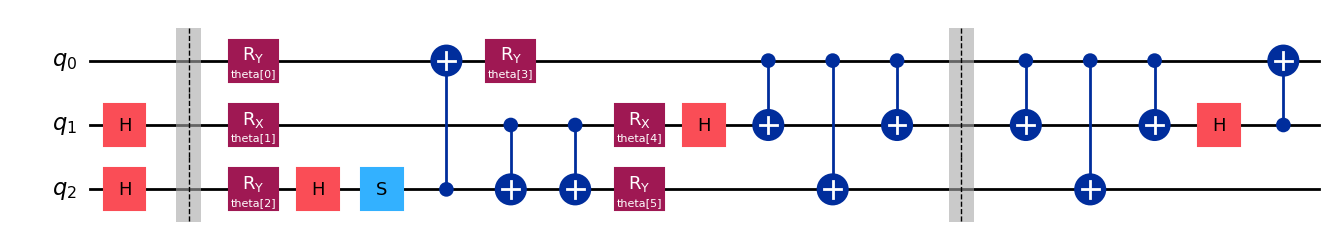

In [21]:
### Benchmarking LinearCliffordEncoder

N = 3
L = 2
k = 3

#U = EfficientSU2(N, su2_gates=[ 'ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA-model
#U = EfficientSU2(N, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=L, flatten=True) # fHEA-model
U = randomPQC(N, L) # rPQC-model
D = U.num_parameters
print("D:", D)
#pauli_string = RandomPauliString(N)
pauli_string = 'IXI'
print("input Pauli:", pauli_string)

U_new = LinearCliffordEncoder(U, pauli_string, k) # update with LinearCliffordEncoder (LCE)

for k in range(D):
    gradient_component = TaylorCoefficient(np.eye(D)[k], U_new, pauli_string, np.zeros(D))[0]
    print(k,"-th gradient component:", gradient_component)

U_new.draw(output='mpl', filename='model.pdf')

### Polynomial Time Complexity of Taylor Surrogates

In [ ]:
### EXPERIMENT I: Polynomial Time Complexities of Simulating mHEA

N_max = 128 # maximal number of qubits

# recording growth of the number of parameters in our model
D_values_SU2 = []

# Timing comparison
N_values = range(1, N_max + 1)

# timing the algorithm experimentally
times_naive = []
times_taylor_m1 = []
times_taylor_m2 = []
times_taylor_m3 = []
times_taylor_m4 = []

# theoretical times
times_theory_m1 = []
times_theory_m2 = []
times_theory_m3 = []
times_theory_m4 = []

# recording the summation cardinalities (number of times Gotteman-Knill is called)
cardinalities_m1 = []
cardinalities_m2 = []
cardinalities_m3 = []
cardinalities_m4 = []

# theoretical times rescaled by 1/D
re_times_theory_m1 = []
re_times_theory_m2 = []
re_times_theory_m3 = []
re_times_theory_m4 = []

L = 1 # number of VQU layers

for N in N_values:

    # generate circuit
    unbound_circuit = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA
    D = unbound_circuit.num_parameters # number of bindable VQU parameters
    D_values_SU2.append(D)
    sigma = 1 / D # standard deviation for the parameter sampling
    np.random.seed(7)
    theta = np.random.normal(0, sigma, D)
    bound_circuit = unbound_circuit.assign_parameters(theta)

    # generate random pauli observable
    random.seed(7)
    pauli_string = RandomPauliString(N)

    # timing NaiveQuantumExpectation
    if N < 15:
        unitary = Unitary(bound_circuit)
        observable = PauliStringUnitary(pauli_string)
        start = time.time()
        NaiveQuantumExpectation(unitary, observable)
        end = time.time()
        times_naive.append(None if end - start < 1e-4 else end - start)
    else:
        times_naive.append(None)

    # timing TaylorQuantumExpectation for m=1
    m = 1
    start = time.time()
    _, cardinality_m1 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
    end = time.time()
    times_taylor_m1.append(None if end - start < 1e-4 else end - start)
    cardinalities_m1.append(cardinality_m1)
    times_theory_m1.append((2*D)**m / (math.factorial(m-1)))
    re_times_theory_m1.append((2*D)**m / (math.factorial(m-1) * D))

    # timing TaylorQuantumExpectation for m=2
    if N < 35:
        m = 2
        start = time.time()
        _, cardinality_m2 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m2.append(None if end - start < 1e-4 else end - start)
        cardinalities_m2.append(cardinality_m2)
        times_theory_m2.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m2.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m2.append(None)
        cardinalities_m2.append(None)
        times_theory_m2.append(None)
        re_times_theory_m2.append(None)

    # timing TaylorQuantumExpectation for m=3
    if N < 24:
        m = 3
        start = time.time()
        _, cardinality_m3 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m3.append(None if end - start < 1e-4 else end - start)
        cardinalities_m3.append(cardinality_m3)
        times_theory_m3.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m3.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m3.append(None)
        cardinalities_m3.append(None)
        times_theory_m3.append(None)
        re_times_theory_m3.append(None)

    # timing TaylorQuantumExpectation for m=4
    if N < 8:
        m = 4
        start = time.time()
        _, cardinality_m4 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m4.append(None if end - start < 1e-4 else end - start)
        cardinalities_m4.append(cardinality_m4)
        times_theory_m4.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m4.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m4.append(None)
        cardinalities_m4.append(None)
        times_theory_m4.append(None)
        re_times_theory_m4.append(None)

# store data in a dictionary
data = {
    "N_values": N_values,
    "D_values_SU2": D_values_SU2,
    "times_naive": times_naive,
    "times_taylor_m1": times_taylor_m1,
    "times_taylor_m2": times_taylor_m2,
    "times_taylor_m3": times_taylor_m3,
    "times_taylor_m4": times_taylor_m4,
    "times_theory_m1": times_theory_m1,
    "times_theory_m2": times_theory_m2,
    "times_theory_m3": times_theory_m3,
    "times_theory_m4": times_theory_m4,
    "cardinalities_m1": cardinalities_m1,
    "cardinalities_m2": cardinalities_m2,
    "cardinalities_m3": cardinalities_m3,
    "cardinalities_m4": cardinalities_m4,
    "re_times_theory_m1": re_times_theory_m1,
    "re_times_theory_m2": re_times_theory_m2,
    "re_times_theory_m3": re_times_theory_m3,
    "re_times_theory_m4": re_times_theory_m4
}

# save data
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
### EXPERIMENT Ib: Polynomial Time Complexities of Simulating fHEA

N_max = 128 # maximal number of qubits

# recording growth of the number of parameters in our model
D_values_SU2 = []

# Timing comparison
N_values = range(1, N_max + 1)

# timing the algorithm experimentally
times_naive = []
times_taylor_m1 = []
times_taylor_m2 = []
times_taylor_m3 = []
times_taylor_m4 = []

# theoretical times
times_theory_m1 = []
times_theory_m2 = []
times_theory_m3 = []
times_theory_m4 = []

# recording the summation cardinalities (number of times Gotteman-Knill is called)
cardinalities_m1 = []
cardinalities_m2 = []
cardinalities_m3 = []
cardinalities_m4 = []

# theoretical times rescaled by 1/D
re_times_theory_m1 = []
re_times_theory_m2 = []
re_times_theory_m3 = []
re_times_theory_m4 = []

L = 1 # number of VQU layers

for N in N_values:

    # generate circuit
    unbound_circuit = EfficientSU2(N, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=L, flatten=True) # fHEA
    D = unbound_circuit.num_parameters # number of bindable VQU parameters
    D_values_SU2.append(D)
    sigma = 1 / D # standard deviation for the parameter sampling
    np.random.seed(7)
    theta = np.random.normal(0, sigma, D)
    bound_circuit = unbound_circuit.assign_parameters(theta)

    # generate random pauli observable
    random.seed(7)
    pauli_string = RandomPauliString(N)

    # timing NaiveQuantumExpectation
    if N < 15:
        unitary = Unitary(bound_circuit)
        observable = PauliStringUnitary(pauli_string)
        start = time.time()
        NaiveQuantumExpectation(unitary, observable)
        end = time.time()
        times_naive.append(None if end - start < 1e-4 else end - start)
    else:
        times_naive.append(None)

    # timing TaylorQuantumExpectation for m=1
    m = 1
    start = time.time()
    _, cardinality_m1 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
    end = time.time()
    times_taylor_m1.append(None if end - start < 1e-4 else end - start)
    cardinalities_m1.append(cardinality_m1)
    times_theory_m1.append((2*D)**m / (math.factorial(m-1)))
    re_times_theory_m1.append((2*D)**m / (math.factorial(m-1) * D))

    # timing TaylorQuantumExpectation for m=2
    if N < 35:
        m = 2
        start = time.time()
        _, cardinality_m2 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m2.append(None if end - start < 1e-4 else end - start)
        cardinalities_m2.append(cardinality_m2)
        times_theory_m2.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m2.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m2.append(None)
        cardinalities_m2.append(None)
        times_theory_m2.append(None)
        re_times_theory_m2.append(None)

    # timing TaylorQuantumExpectation for m=3
    if N < 24:
        m = 3
        start = time.time()
        _, cardinality_m3 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m3.append(None if end - start < 1e-4 else end - start)
        cardinalities_m3.append(cardinality_m3)
        times_theory_m3.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m3.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m3.append(None)
        cardinalities_m3.append(None)
        times_theory_m3.append(None)
        re_times_theory_m3.append(None)

    # timing TaylorQuantumExpectation for m=4
    if N < 8:
        m = 4
        start = time.time()
        _, cardinality_m4 = TaylorQuantumExpectation(unbound_circuit, pauli_string, theta, m)
        end = time.time()
        times_taylor_m4.append(None if end - start < 1e-4 else end - start)
        cardinalities_m4.append(cardinality_m4)
        times_theory_m4.append((2*D)**m / (math.factorial(m-1)))
        re_times_theory_m4.append((2*D)**m / (math.factorial(m-1) * D))
    else:
        times_taylor_m4.append(None)
        cardinalities_m4.append(None)
        times_theory_m4.append(None)
        re_times_theory_m4.append(None)

# store data in a dictionary
data1b = {
    "N_values": N_values,
    "D_values_SU2": D_values_SU2,
    "times_naive": times_naive,
    "times_taylor_m1": times_taylor_m1,
    "times_taylor_m2": times_taylor_m2,
    "times_taylor_m3": times_taylor_m3,
    "times_taylor_m4": times_taylor_m4,
    "times_theory_m1": times_theory_m1,
    "times_theory_m2": times_theory_m2,
    "times_theory_m3": times_theory_m3,
    "times_theory_m4": times_theory_m4,
    "cardinalities_m1": cardinalities_m1,
    "cardinalities_m2": cardinalities_m2,
    "cardinalities_m3": cardinalities_m3,
    "cardinalities_m4": cardinalities_m4,
    "re_times_theory_m1": re_times_theory_m1,
    "re_times_theory_m2": re_times_theory_m2,
    "re_times_theory_m3": re_times_theory_m3,
    "re_times_theory_m4": re_times_theory_m4
}

# save data
with open("data1b.pkl", "wb") as f:
    pickle.dump(data1b, f)

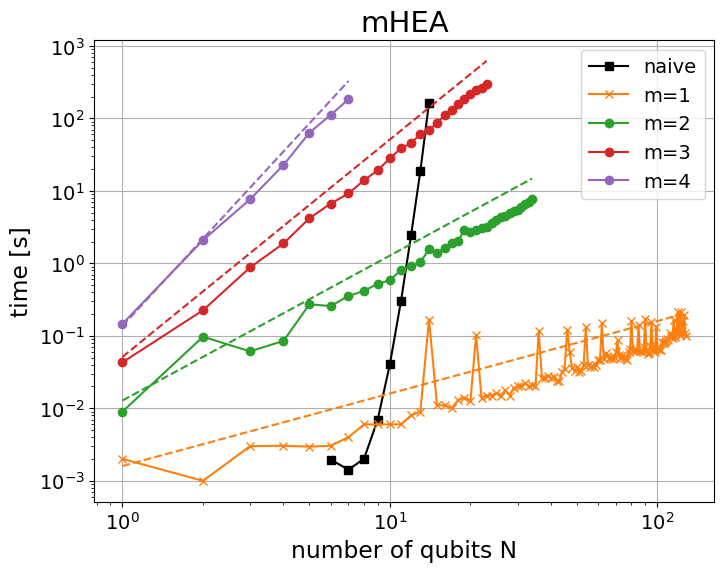

In [22]:
### Plotting the Results of EXPERIMENT I

# load data
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
D_values_SU2 = data["D_values_SU2"]
times_naive = data["times_naive"]
times_taylor_m1 = data["times_taylor_m1"]
times_taylor_m2 = data["times_taylor_m2"]
times_taylor_m3 = data["times_taylor_m3"]
times_taylor_m4 = data["times_taylor_m4"]
times_theory_m1 = data["times_theory_m1"]
times_theory_m2 = data["times_theory_m2"]
times_theory_m3 = data["times_theory_m3"]
times_theory_m4 = data["times_theory_m4"]
cardinalities_m1 = data["cardinalities_m1"]
cardinalities_m2 = data["cardinalities_m2"]
cardinalities_m3 = data["cardinalities_m3"]
cardinalities_m4 = data["cardinalities_m4"]
re_times_theory_m1 = data["re_times_theory_m1"]
re_times_theory_m2 = data["re_times_theory_m2"]
re_times_theory_m3 = data["re_times_theory_m3"]
re_times_theory_m4 = data["re_times_theory_m4"]

plt.figure(figsize=(8, 6))

font_size = 14

# empirical times
plt.plot(N_values, times_naive, label='naive', marker='s', color="black")
plt.plot(N_values, times_taylor_m1, label='m=1', marker='x', color='C1')
plt.plot(N_values, times_taylor_m2, label='m=2', marker='o', color='C2')
plt.plot(N_values, times_taylor_m3, label='m=3', marker='o', color='C3')
plt.plot(N_values, times_taylor_m4, label='m=4', marker='o', color='C4')

# theoretical times
constant = 2 * 1e-4 # constant in big O
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m1], linestyle='--', color='C1', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m2], linestyle='--', color='C2', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m3], linestyle='--', color='C3', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m4], linestyle='--', color='C4', label='_nolegend_')

plt.xlabel('number of qubits N', fontsize=font_size * 1.2)
plt.ylabel('time [s]', fontsize=font_size * 1.2)
plt.title('mHEA', fontsize=font_size * 1.5)
plt.tick_params(axis='both', which='major', labelsize=font_size * 1)
plt.legend(fontsize=font_size * 1)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.savefig("polynomial_mHEA.pdf", format="pdf")
plt.show()

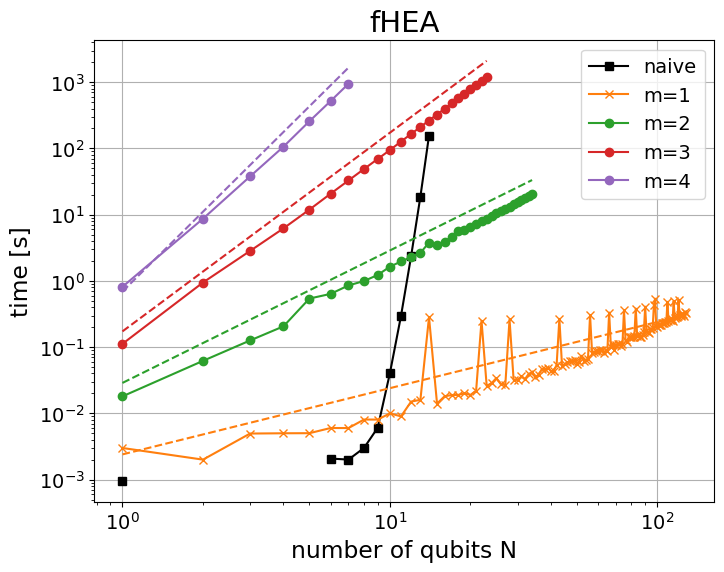

In [23]:
### Plotting the Results of EXPERIMENT Ib

# load data
with open("data1b.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
D_values_SU2 = data["D_values_SU2"]
times_naive = data["times_naive"]
times_taylor_m1 = data["times_taylor_m1"]
times_taylor_m2 = data["times_taylor_m2"]
times_taylor_m3 = data["times_taylor_m3"]
times_taylor_m4 = data["times_taylor_m4"]
times_theory_m1 = data["times_theory_m1"]
times_theory_m2 = data["times_theory_m2"]
times_theory_m3 = data["times_theory_m3"]
times_theory_m4 = data["times_theory_m4"]
cardinalities_m1 = data["cardinalities_m1"]
cardinalities_m2 = data["cardinalities_m2"]
cardinalities_m3 = data["cardinalities_m3"]
cardinalities_m4 = data["cardinalities_m4"]
re_times_theory_m1 = data["re_times_theory_m1"]
re_times_theory_m2 = data["re_times_theory_m2"]
re_times_theory_m3 = data["re_times_theory_m3"]
re_times_theory_m4 = data["re_times_theory_m4"]

plt.figure(figsize=(8, 6))

font_size = 14

# empirical times
plt.plot(N_values, times_naive, label='naive', marker='s', color="black")
plt.plot(N_values, times_taylor_m1, label='m=1', marker='x', color='C1')
plt.plot(N_values, times_taylor_m2, label='m=2', marker='o', color='C2')
plt.plot(N_values, times_taylor_m3, label='m=3', marker='o', color='C3')
plt.plot(N_values, times_taylor_m4, label='m=4', marker='o', color='C4')

# theoretical times
constant = 2 * 1e-4 # constant in big O
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m1], linestyle='--', color='C1', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m2], linestyle='--', color='C2', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m3], linestyle='--', color='C3', label='_nolegend_')
plt.plot(N_values, [constant * t if t is not None else None for t in times_theory_m4], linestyle='--', color='C4', label='_nolegend_')

plt.xlabel('number of qubits N', fontsize=font_size * 1.2)
plt.ylabel('time [s]', fontsize=font_size * 1.2)
plt.title('fHEA', fontsize=font_size * 1.5)
plt.tick_params(axis='both', which='major', labelsize=font_size * 1)
plt.legend(fontsize=font_size * 1)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.savefig("polynomial_fHEA.pdf", format="pdf")
plt.show()

### Computational Phase Transitions of Taylor Surrogates

In [15]:
### EXPERIMENT II: Behaviour of the Truncation Threshold m as a Function of the Number of Qubits N (takes approx 15min with Nvidia Geforce GTX1650)

N_max = int(1e4) # maximal number of qubits
eps = 1e-6 # approximation error tolerance

#N_values = range(2, N_max + 1)
N_values = np.unique(np.logspace(np.log10(1), np.log10(N_max), num=50, dtype=int))

# recording the truncation thresholds
m_values_zero = []
m_values_exp = []
m_values_square = []
m_values_lin = []
m_values_sqrt = []
m_values_cube = []
m_values_quad = []
m_values_log = []
m_values_const = []

for N in N_values:
    D = 2*N*(N+1)

    # parameter initialization
    np.random.seed(7)
    theta_zero = np.zeros(D)
    theta_exp = np.random.normal(0, np.exp(-D), D)
    theta_square = np.random.normal(0, 1/D**2, D)
    theta_lin = np.random.normal(0, 1/D, D)
    theta_sqrt = np.random.normal(0, 1/np.sqrt(D), D)
    theta_cube = np.random.normal(0, 1/D**(1/3), D)
    theta_quad = np.random.normal(0, 1/D**(1/5), D)
    theta_log = np.random.normal(0, 1/np.log(D), D)
    theta_const = np.random.normal(0, 1, D)

    # truncation evaluation
    m_theta_zero = m_optimal(eps, theta_zero)
    m_theta_exp = m_optimal(eps, theta_exp)
    m_theta_square = m_optimal(eps, theta_square)
    m_theta_lin = m_optimal(eps, theta_lin)
    m_theta_sqrt = m_optimal(eps, theta_sqrt)
    m_theta_cube = m_optimal(eps, theta_cube)
    m_theta_quad = m_optimal(eps, theta_quad)
    m_theta_log = m_optimal(eps, theta_log)
    m_theta_const = m_optimal(eps, theta_const)

    m_values_zero.append(m_theta_zero)
    m_values_exp.append(m_theta_exp)
    m_values_square.append(m_theta_square)
    m_values_lin.append(m_theta_lin)
    m_values_sqrt.append(m_theta_sqrt)
    m_values_cube.append(m_theta_cube)
    m_values_quad.append(m_theta_quad)
    m_values_log.append(m_theta_log)
    m_values_const.append(m_theta_const)

# store data in a dictionary
data2 = {
    "N_values": N_values,
    "m_values_zero": m_values_zero,
    "m_values_exp": m_values_exp,
    "m_values_square": m_values_square,
    "m_values_lin": m_values_lin,
    "m_values_sqrt": m_values_sqrt,
    "m_values_cube": m_values_cube,
    "m_values_quad": m_values_quad,
    "m_values_log": m_values_log,
    "m_values_const": m_values_const,
}

# save data
with open("data2.pkl", "wb") as f:
    pickle.dump(data2, f)


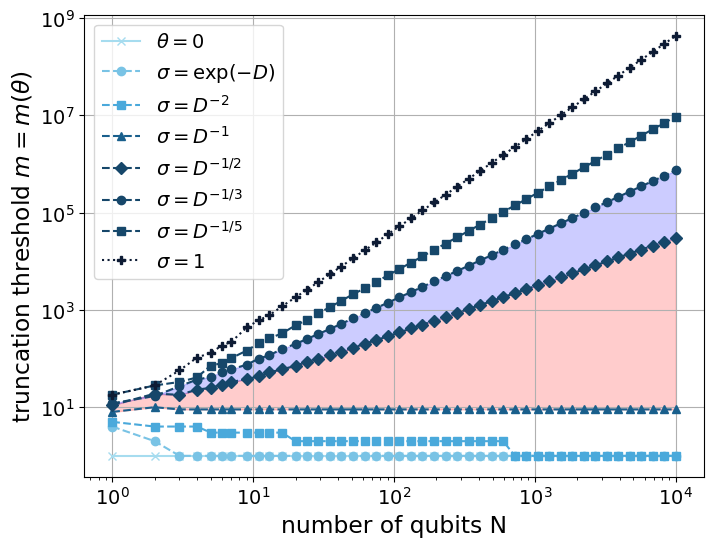

In [17]:
### Plotting the Results of EXPERIMENT II

# load data
with open("data2.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
m_values_zero = data["m_values_zero"]
m_values_exp = data["m_values_exp"]
m_values_square = data["m_values_square"]
m_values_lin = data["m_values_lin"]
m_values_sqrt = data["m_values_sqrt"]
m_values_cube = data["m_values_cube"]
m_values_quad = data["m_values_quad"]
m_values_log = data["m_values_log"]
m_values_const = data["m_values_const"]

plt.figure(figsize=(8, 6))

font_size = 14

def trim_tail(values, n=20000):
    trimmed = np.array(values, dtype=float)
    if len(trimmed) > n + 1:
        trimmed[-n-1:-1] = np.nan
    return trimmed

m_values_zero_trimmed = trim_tail(m_values_zero)
m_values_exp_trimmed = trim_tail(m_values_exp)
m_values_square_trimmed = trim_tail(m_values_square)
m_values_lin_trimmed = trim_tail(m_values_lin)
m_values_sqrt_trimmed = trim_tail(m_values_sqrt)
m_values_cube_trimmed = trim_tail(m_values_cube)
m_values_quad_trimmed = trim_tail(m_values_quad)
m_values_log_trimmed = trim_tail(m_values_log)
m_values_const_trimmed = trim_tail(m_values_const)

# Plot
plt.plot(N_values, m_values_zero_trimmed, label=r'$\theta=0$', marker='x', color='#a6dcef')
plt.plot(N_values, m_values_exp_trimmed, linestyle='--', label=r'$\sigma=\exp(-D)$', marker='o', color='#79c3e5')
plt.plot(N_values, m_values_square_trimmed, linestyle='--', label=r'$\sigma=D^{-2}$', marker='s', color='#4aa9db')
plt.plot(N_values, m_values_lin_trimmed, linestyle='--', label=r'$\sigma=D^{-1}$', marker='^', color='#195f8c')
plt.plot(N_values, m_values_sqrt_trimmed, linestyle='--', label=r'$\sigma=D^{-1/2}$', marker='D', color='#16476a')
plt.plot(N_values, m_values_cube_trimmed, linestyle='--', label=r'$\sigma=D^{-1/3}$', marker='o', color='#16476a')
plt.plot(N_values, m_values_quad_trimmed, linestyle='--', label=r'$\sigma=D^{-1/5}$', marker='s', color='#16476a')
#plt.plot(N_values, m_values_log_trimmed, linestyle=':', label=r'$\sigma=\log(D)^{-1}$', marker='v', color='#12314f')
plt.plot(N_values, m_values_const_trimmed, linestyle=':', label=r'$\sigma=1$', marker='P', color='#0d1b34')

plt.fill_between(N_values, m_values_lin, m_values_sqrt, color='red', alpha=0.2) # shading the area between D^{-1} and D^{-1/2}
plt.fill_between(N_values, m_values_sqrt, m_values_cube, color='blue', alpha=0.2) # shading the area between D^{-1/2} and D^{-1/3}

plt.xlabel('number of qubits N', fontsize=font_size * 1.2)
plt.ylabel(r'truncation threshold $m=m(\theta)$', fontsize=font_size * 1.2)
#plt.title(r'Qubit Scaling for $\theta\sim\mathcal{N}(0,\sigma^2)$', fontsize=font_size * 1.5)
plt.tick_params(axis='both', which='major', labelsize=font_size * 1)
plt.legend(fontsize=font_size * 1)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.savefig("truncation_number_scaling.pdf", format="pdf")
plt.show()

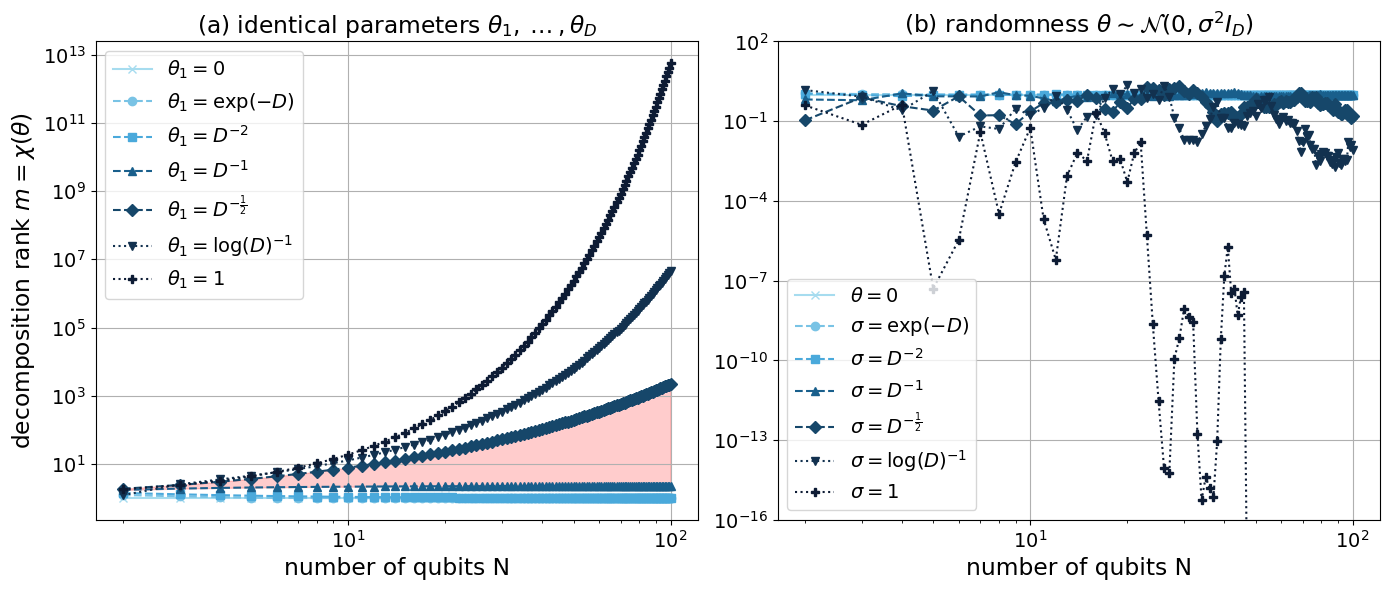

In [6]:
### EXPERIMENT IIa: Behaviour of the Decomposition Number m reported by Bravyi et al.

N_max = int(1e2) # maximal number of qubits
eps = 1e-6 # approximation error tolerance

N_values = range(2, N_max + 1)

# recording the Bravyi-ranks
m_Bravyi_zero = []
m_Bravyi_exp = []
m_Bravyi_square = []
m_Bravyi_lin = []
m_Bravyi_sqrt = []
m_Bravyi_log = []
m_Bravyi_const = []
m_Bravyi_exp_random = []
m_Bravyi_square_random = []
m_Bravyi_lin_random = []
m_Bravyi_sqrt_random = []
m_Bravyi_log_random = []
m_Bravyi_const_random = []

# computing the decomposition number m in the works of Bravyi et al. (we have an extra square because we simulate <\psi(\theta)|H|\psi(\theta)>)
def m_Bravyi(theta):
    prod = 1
    D = theta.size
    for k in range(D):
        prod *= (np.cos(theta[k]/2) + np.tan(np.pi/8)*np.sin(theta[k]/2))**4
    return prod

for N in N_values:
    D = N

    # parameter initialization
    np.random.seed(7)
    theta_zero = np.zeros(D)
    theta_exp = np.exp(-D) * np.ones(D)
    theta_square = 1/D**2 * np.ones(D)
    theta_lin = 1/D * np.ones(D)
    theta_sqrt = 1/np.sqrt(D) * np.ones(D)
    theta_log = 1/np.log(D) * np.ones(D)
    theta_const = np.ones(D)
    theta_exp_random = np.random.normal(0, np.exp(-D), D)
    theta_square_random = np.random.normal(0, 1/D**2, D)
    theta_lin_random = np.random.normal(0, 1/D, D)
    theta_sqrt_random = np.random.normal(0, 1/np.sqrt(D), D)
    theta_log_random = np.random.normal(0, 1/np.log(D), D)
    theta_const_random = np.random.normal(0, 1, D)

    # Bravyi-rank evaluation
    m_Bravyi_zero.append(m_Bravyi(theta_zero))
    m_Bravyi_exp.append(m_Bravyi(theta_exp))
    m_Bravyi_square.append(m_Bravyi(theta_square))
    m_Bravyi_lin.append(m_Bravyi(theta_lin))
    m_Bravyi_sqrt.append(m_Bravyi(theta_sqrt))
    m_Bravyi_log.append(m_Bravyi(theta_log))
    m_Bravyi_const.append(m_Bravyi(theta_const))
    m_Bravyi_exp_random.append(m_Bravyi(theta_exp_random))
    m_Bravyi_square_random.append(m_Bravyi(theta_square_random))
    m_Bravyi_lin_random.append(m_Bravyi(theta_lin_random))
    m_Bravyi_sqrt_random.append(m_Bravyi(theta_sqrt_random))
    m_Bravyi_log_random.append(m_Bravyi(theta_log_random))
    m_Bravyi_const_random.append(m_Bravyi(theta_const_random))

### Plotting the results of EXPERIMENT III

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
font_size = 14

# Colors and markers matching the second plot style
colors = ['#a6dcef', '#79c3e5', '#4aa9db', '#195f8c', '#16476a', '#12314f', '#0d1b34']
markers = ['x', 'o', 's', '^', 'D', 'v', 'P']
linestyles = ['-', '--', '--', '--', '--', ':', ':']

# --- Panel (a): Identical parameters ---
axs[0].plot(N_values, m_Bravyi_zero, label=r'$\theta_1=0$', marker=markers[0], color=colors[0], linestyle=linestyles[0])
axs[0].plot(N_values, m_Bravyi_exp, label=r'$\theta_1=\exp(-D)$', marker=markers[1], color=colors[1], linestyle=linestyles[1])
axs[0].plot(N_values, m_Bravyi_square, label=r'$\theta_1=D^{-2}$', marker=markers[2], color=colors[2], linestyle=linestyles[2])
axs[0].plot(N_values, m_Bravyi_lin, label=r'$\theta_1=D^{-1}$', marker=markers[3], color=colors[3], linestyle=linestyles[3])
axs[0].plot(N_values, m_Bravyi_sqrt, label=r'$\theta_1=D^{-\frac{1}{2}}$', marker=markers[4], color=colors[4], linestyle=linestyles[4])
axs[0].plot(N_values, m_Bravyi_log, label=r'$\theta_1=\log(D)^{-1}$', marker=markers[5], color=colors[5], linestyle=linestyles[5])
axs[0].plot(N_values, m_Bravyi_const, label=r'$\theta_1=1$', marker=markers[6], color=colors[6], linestyle=linestyles[6])

axs[0].fill_between(N_values, m_Bravyi_lin, m_Bravyi_sqrt, color='red', alpha=0.2)

axs[0].set_xlabel('number of qubits N', fontsize=font_size * 1.2)
axs[0].set_ylabel(r'decomposition rank $m=\chi(\theta)$', fontsize=font_size * 1.2)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].legend(fontsize=font_size)
axs[0].set_title(r'(a) identical parameters $\theta_1,\dots,\theta_D$', fontsize=font_size * 1.2)

# --- Panel (b): Random parameters ---
axs[1].plot(N_values, m_Bravyi_zero, label=r'$\theta=0$', marker=markers[0], color=colors[0], linestyle=linestyles[0])
axs[1].plot(N_values, m_Bravyi_exp_random, label=r'$\sigma=\exp(-D)$', marker=markers[1], color=colors[1], linestyle=linestyles[1])
axs[1].plot(N_values, m_Bravyi_square_random, label=r'$\sigma=D^{-2}$', marker=markers[2], color=colors[2], linestyle=linestyles[2])
axs[1].plot(N_values, m_Bravyi_lin_random, label=r'$\sigma=D^{-1}$', marker=markers[3], color=colors[3], linestyle=linestyles[3])
axs[1].plot(N_values, m_Bravyi_sqrt_random, label=r'$\sigma=D^{-\frac{1}{2}}$', marker=markers[4], color=colors[4], linestyle=linestyles[4])
axs[1].plot(N_values, m_Bravyi_log_random, label=r'$\sigma=\log(D)^{-1}$', marker=markers[5], color=colors[5], linestyle=linestyles[5])
axs[1].plot(N_values, m_Bravyi_const_random, label=r'$\sigma=1$', marker=markers[6], color=colors[6], linestyle=linestyles[6])

axs[1].set_xlabel('number of qubits N', fontsize=font_size * 1.2)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-16,100)
axs[1].grid(True)
axs[1].legend(fontsize=font_size)
axs[1].set_title(r'(b) randomness $\theta\sim\mathcal{N}(0,\sigma^2I_D)$', fontsize=font_size * 1.2)

plt.tight_layout()
plt.savefig("bravyi_scaling.pdf", format="pdf")  
plt.show()


### Benchmarking the Gradient Norm at Zero of Linear-Depth PQCs

In [4]:
### EXPERIMENT III: Escaping Barren-Plateaus in mHEA-circuit

N_max = 16 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []

    for seed in range(number_of_runs):
        L = N # number of ansatz layers
        unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use mHEA here
        D = unbound_circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta_zero = np.zeros(D)
        gradient_theta_zero = TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_theta_zero_noLCE = TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
    print("qubit:", N)
        
# store data in a dictionary
data3 = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
}

# save data
with open("data3.pkl", "wb") as f:
    pickle.dump(data3, f)

qubit: 2
qubit: 3
qubit: 4
qubit: 5
qubit: 6
qubit: 7
qubit: 8
qubit: 9
qubit: 10
qubit: 11
qubit: 12
qubit: 13
qubit: 14
qubit: 15
qubit: 16


In [5]:
### EXPERIMENT IV: Generalization to arbitrary Observables

N_max = 16 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero2_data = []
gradient_norms_zero_data_noLCE = []
gradient_norms_zero2_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []
    gradient_norms_zero2_runs = []
    gradient_norms_zero2_runs_noLCE = []

    for seed in range(number_of_runs):
        L = N # number of ansatz layers
        I = int(np.sqrt(N)) # number of Pauli-strings in observable
        random.seed(seed)
        np.random.seed(seed)
        pauli_strings = RandomPauliStrings(N, I)
        coefficients = np.random.uniform(-1, 1, I)
        unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use mHWE here
        D = unbound_circuit_noLCE.num_parameters

        total_gradient = 0
        j = random.randint(0, I - 1) # pick random Pauli-term to construct LCE
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_strings[j], random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)

        theta_zero = np.zeros(D)

        gradient_theta_zero = np.zeros(D)
        gradient_theta_zero_noLCE = np.zeros(D)
        gradient_theta_zero2 = np.zeros(D)
        gradient_theta_zero2_noLCE = np.zeros(D)

        for i in range(I):
            pauli_string = pauli_strings[i]
            gradient_theta_zero += TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
            gradient_theta_zero_noLCE += TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
            gradient_theta_zero2 += coefficients[j] * np.array(TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1))
            gradient_theta_zero2_noLCE += coefficients[j] * np.array(TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1))

        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        gradient_norms_zero2_runs.append(np.linalg.norm(gradient_theta_zero2))
        gradient_norms_zero2_runs_noLCE.append(np.linalg.norm(gradient_theta_zero2_noLCE))

    print("qubit:", N)        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
    gradient_norms_zero2_data.append(gradient_norms_zero2_runs)
    gradient_norms_zero2_data_noLCE.append(gradient_norms_zero2_runs_noLCE)
        
# store data in a dictionary
data4 = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
    "gradient_norms_zero2_data": gradient_norms_zero2_data,
    "gradient_norms_zero2_data_noLCE": gradient_norms_zero2_data_noLCE,
}

# save data
with open("data4.pkl", "wb") as f:
    pickle.dump(data4, f)

qubit: 2
qubit: 3
qubit: 4
qubit: 5
qubit: 6
qubit: 7
qubit: 8
qubit: 9
qubit: 10
qubit: 11
qubit: 12
qubit: 13
qubit: 14
qubit: 15
qubit: 16


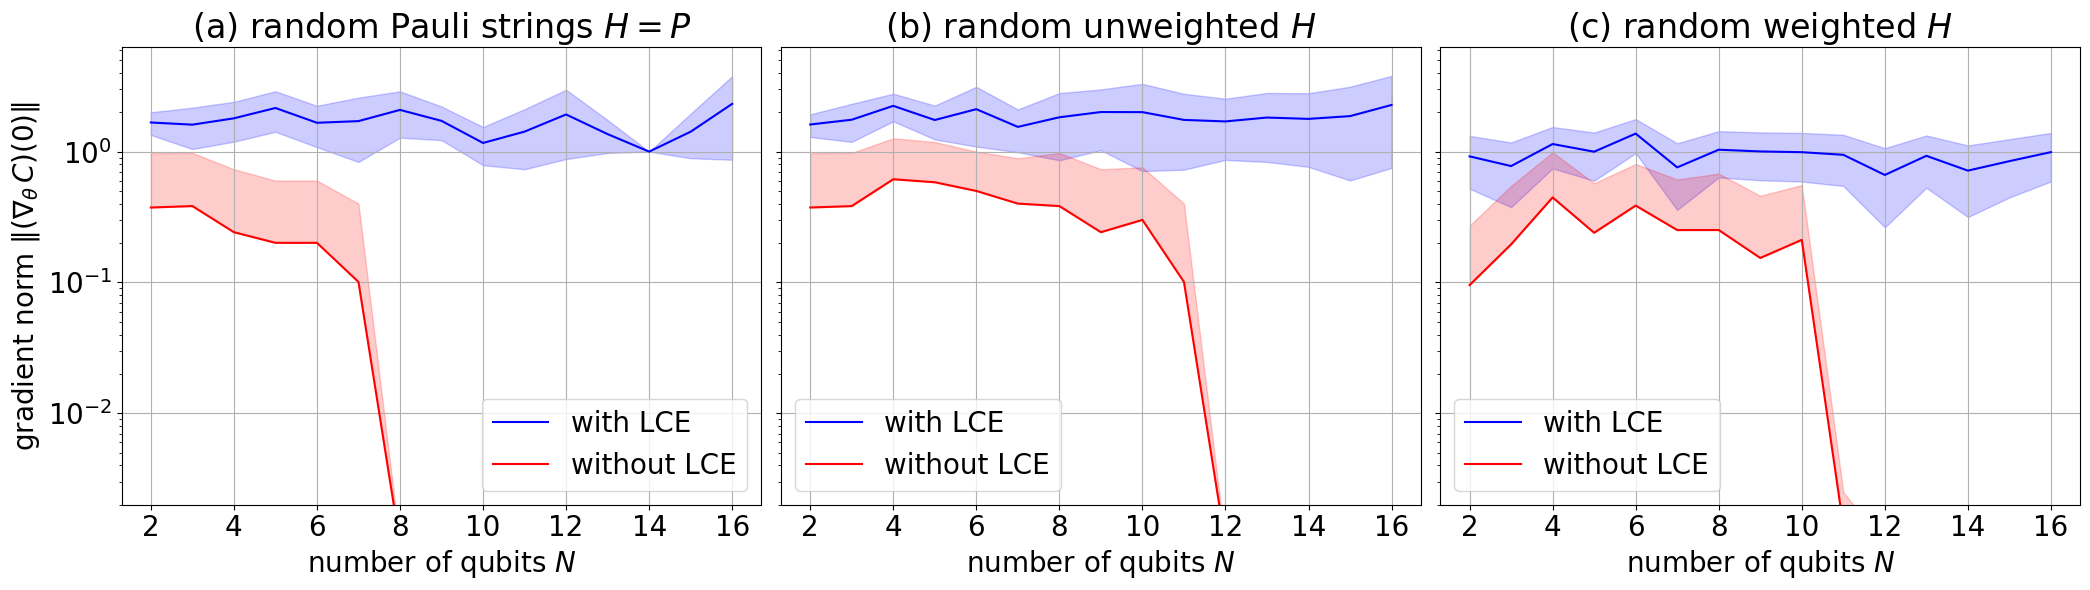

In [12]:
### Plotting the Results of EXPERIMENT III and IV
from matplotlib.ticker import MaxNLocator

# ========== Load Experiment III Data ==========
with open("data3.pkl", "rb") as f:
    data3 = pickle.load(f)

N_values3 = data3["N_values"]
grad_norms_LCE_3 = np.array(data3["gradient_norms_zero_data"]) + 1e-3
grad_norms_noLCE_3 = np.array(data3["gradient_norms_zero_data_noLCE"]) + 1e-3

means3 = np.mean(grad_norms_LCE_3, axis=1)
stds3 = np.std(grad_norms_LCE_3, axis=1)
means3_noLCE = np.mean(grad_norms_noLCE_3, axis=1)
stds3_noLCE = np.std(grad_norms_noLCE_3, axis=1)

# ========== Load Experiment IV Data ==========
with open("data4.pkl", "rb") as f:
    data4 = pickle.load(f)

N_values4 = data4["N_values"]
grad_norms_LCE_4a = np.array(data4["gradient_norms_zero_data"]) + 1e-3
grad_norms_noLCE_4a = np.array(data4["gradient_norms_zero_data_noLCE"]) + 1e-3
grad_norms_LCE_4b = np.array(data4["gradient_norms_zero2_data"]) + 1e-3
grad_norms_noLCE_4b = np.array(data4["gradient_norms_zero2_data_noLCE"]) + 1e-3

means4a = np.mean(grad_norms_LCE_4a, axis=1)
stds4a = np.std(grad_norms_LCE_4a, axis=1)
means4a_noLCE = np.mean(grad_norms_noLCE_4a, axis=1)
stds4a_noLCE = np.std(grad_norms_noLCE_4a, axis=1)

means4b = np.mean(grad_norms_LCE_4b, axis=1)
stds4b = np.std(grad_norms_LCE_4b, axis=1)
means4b_noLCE = np.mean(grad_norms_noLCE_4b, axis=1)
stds4b_noLCE = np.std(grad_norms_noLCE_4b, axis=1)

stds4b, stds4b_noLCE = np.minimum(np.std(grad_norms_LCE_4b, 1), 0.4), np.std(grad_norms_noLCE_4b, 1)

# ========== Combined Plot ==========
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
font_size = 20

# ---- Subplot (a)
ax = axes[0]
ax.plot(N_values3, means3, label="with LCE", color='b')
ax.plot(N_values3, means3_noLCE, label="without LCE", color='r')
ax.fill_between(N_values3, means3 - stds3, means3 + stds3, color='b', alpha=0.2)
ax.fill_between(N_values3, means3_noLCE, means3_noLCE + stds3_noLCE, color='r', alpha=0.2)
ax.set_title(r"(a) random Pauli strings $H=P$", fontsize=font_size * 1.2)
ax.set_xlabel(r'number of qubits $N$', fontsize=font_size)
ax.set_ylabel(r'gradient norm $\|(\nabla_\theta \,C)(0)\|$', fontsize=font_size)
ax.legend(fontsize=font_size)
ax.grid(True)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# ---- Subplot (b)
ax = axes[1]
ax.plot(N_values4, means4a, label="with LCE", color='b')
ax.plot(N_values4, means4a_noLCE, label="without LCE", color='r')
ax.fill_between(N_values4, means4a - stds4a, means4a + stds4a, color='b', alpha=0.2)
ax.fill_between(N_values4, means4a_noLCE, means4a_noLCE + stds4a_noLCE, color='r', alpha=0.2)
ax.set_title(r"(b) random unweighted $H$", fontsize=font_size * 1.2)
ax.set_xlabel(r'number of qubits $N$', fontsize=font_size)
ax.legend(fontsize=font_size)
ax.grid(True)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# ---- Subplot (c)
ax = axes[2]
ax.plot(N_values4, means4b, label="with LCE", color='b')
ax.plot(N_values4, means4b_noLCE, label="without LCE", color='r')
ax.fill_between(N_values4, means4b - stds4b, means4b + stds4b, color='b', alpha=0.2)
ax.fill_between(N_values4, means4b_noLCE, means4b_noLCE + stds4b_noLCE, color='r', alpha=0.2)
ax.set_title(r"(c) random weighted $H$", fontsize=font_size * 1.2)
ax.set_xlabel(r'number of qubits $N$', fontsize=font_size)
ax.legend(fontsize=font_size)
ax.grid(True)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# ---- Uniform Y-axis range across all subplots
y_mins = [ax.get_ylim()[0] for ax in axes]
y_maxs = [ax.get_ylim()[1] for ax in axes]
y_min, y_max = min(y_mins), max(y_maxs) * 1.1
for ax in axes:
    ax.set_ylim(1/5*1e-2, y_max)

plt.tight_layout()
plt.savefig("benchmarking-zero-gradient-norm.pdf", format="pdf")
plt.show()


### Benchmarking the Gradient Norm at Zero of Shallow PQCs

In [7]:
### EXPERIMENT III_shallow: Escaping Barren-Plateaus in mHEA-circuits

N_max = 32 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []

    for seed in range(number_of_runs):
        L = 1 # number of ansatz layers
        unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use mHEA here
        D = unbound_circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta_zero = np.zeros(D)
        gradient_theta_zero = TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_theta_zero_noLCE = TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
        
# store data in a dictionary
data3_shallow = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
}

# save data
with open("data3_shallow.pkl", "wb") as f:
    pickle.dump(data3_shallow, f)

In [8]:
### EXPERIMENT IIIa_shallow: Escaping Barren-Plateaus for fHEA-circuits

N_max = 32 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []

    for seed in range(number_of_runs):
        L = 1 # number of ansatz layers
        unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=L, flatten=True) # we use fHEA here
        D = unbound_circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta_zero = np.zeros(D)
        gradient_theta_zero = TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_theta_zero_noLCE = TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
        
# store data in a dictionary
data3a_shallow = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
}

# save data
with open("data3a_shallow.pkl", "wb") as f:
    pickle.dump(data3a_shallow, f)

In [9]:
### EXPERIMENT IIIb_shallow: Escaping Barren-Plateaus for rPQC-circuits

N_max = 32 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []

    for seed in range(number_of_runs):
        L = 1 # number of ansatz layers
        unbound_circuit_noLCE = randomPQC(N, 5) # we use rPQC here
        D = unbound_circuit_noLCE.num_parameters
        random.seed(seed)
        np.random.seed(seed)
        pauli_string = RandomPauliString(N)
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)
        
        theta_zero = np.zeros(D)
        gradient_theta_zero = TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_theta_zero_noLCE = TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
        
# store data in a dictionary
data3b_shallow = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
}

# save data
with open("data3b_shallow.pkl", "wb") as f:
    pickle.dump(data3b_shallow, f)

In [10]:
### EXPERIMENT IV_shallow: Generalization to arbitrary Observables

N_max = 32 # maximal number of qubits

number_of_runs = 10 # number of runs for the average data

N_values = range(2, N_max + 1)

# recording the norm of the gradient
gradient_norms_zero_data = []
gradient_norms_zero2_data = []
gradient_norms_zero_data_noLCE = []
gradient_norms_zero2_data_noLCE = []

for N in N_values:

    gradient_norms_zero_runs = []
    gradient_norms_zero_runs_noLCE = []
    gradient_norms_zero2_runs = []
    gradient_norms_zero2_runs_noLCE = []

    for seed in range(number_of_runs):
        L = 1 # number of ansatz layers
        I = int(np.sqrt(N)) # number of Pauli-strings in observable
        random.seed(seed)
        np.random.seed(seed)
        pauli_strings = RandomPauliStrings(N, I)
        coefficients = np.random.uniform(-1, 1, I)
        unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # we use mHWE here
        D = unbound_circuit_noLCE.num_parameters

        total_gradient = 0
        j = random.randint(0, I - 1) # pick random Pauli-term to construct LCE
        unbound_circuit = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_strings[j], random.randint(0, D-1)) # modify the PQC with the Linear Clifford Encoder (LCE)

        theta_zero = np.zeros(D)

        gradient_theta_zero = np.zeros(D)
        gradient_theta_zero_noLCE = np.zeros(D)
        gradient_theta_zero2 = np.zeros(D)
        gradient_theta_zero2_noLCE = np.zeros(D)

        for i in range(I):
            pauli_string = pauli_strings[i]
            gradient_theta_zero += TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1)
            gradient_theta_zero_noLCE += TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1)
            gradient_theta_zero2 += coefficients[j] * np.array(TaylorQuantumGradient(unbound_circuit, pauli_string, theta_zero, 1))
            gradient_theta_zero2_noLCE += coefficients[j] * np.array(TaylorQuantumGradient(unbound_circuit_noLCE, pauli_string, theta_zero, 1))

        gradient_norms_zero_runs.append(np.linalg.norm(gradient_theta_zero))
        gradient_norms_zero_runs_noLCE.append(np.linalg.norm(gradient_theta_zero_noLCE))
        gradient_norms_zero2_runs.append(np.linalg.norm(gradient_theta_zero2))
        gradient_norms_zero2_runs_noLCE.append(np.linalg.norm(gradient_theta_zero2_noLCE))

    print("qubit:", N)        
        
    gradient_norms_zero_data.append(gradient_norms_zero_runs)
    gradient_norms_zero_data_noLCE.append(gradient_norms_zero_runs_noLCE)
    gradient_norms_zero2_data.append(gradient_norms_zero2_runs)
    gradient_norms_zero2_data_noLCE.append(gradient_norms_zero2_runs_noLCE)
        
# store data in a dictionary
data4_shallow = {
    "N_values": N_values,
    "gradient_norms_zero_data": gradient_norms_zero_data,
    "gradient_norms_zero_data_noLCE": gradient_norms_zero_data_noLCE,
    "gradient_norms_zero2_data": gradient_norms_zero2_data,
    "gradient_norms_zero2_data_noLCE": gradient_norms_zero2_data_noLCE,
}

# save data
with open("data4_shallow.pkl", "wb") as f:
    pickle.dump(data4_shallow, f)

qubit: 2
qubit: 3
qubit: 4
qubit: 5
qubit: 6
qubit: 7
qubit: 8
qubit: 9
qubit: 10
qubit: 11
qubit: 12
qubit: 13
qubit: 14
qubit: 15
qubit: 16
qubit: 17
qubit: 18
qubit: 19
qubit: 20
qubit: 21
qubit: 22
qubit: 23
qubit: 24
qubit: 25
qubit: 26
qubit: 27
qubit: 28
qubit: 29
qubit: 30
qubit: 31
qubit: 32


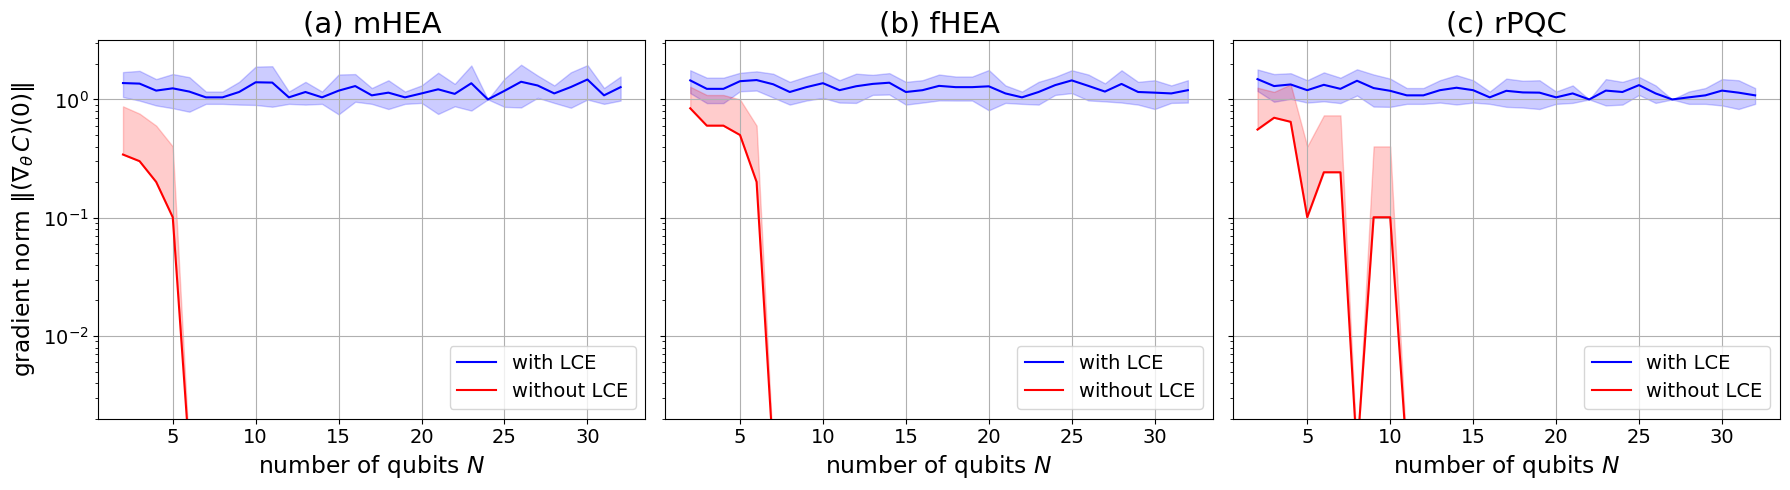

In [24]:
### Plotting the Results of EXPERIMENT IIIab_shallow

font_size = 14

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- Panel (a): mHEA ---
with open("data3_shallow.pkl", "rb") as f:
    data = pickle.load(f)
N = data["N_values"]
g = np.array(data["gradient_norms_zero_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.std(g, 1), np.std(g0, 1)
ax = axes[0]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title("(a) mHEA", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.set_ylabel(r'gradient norm $\|(\nabla_\theta \,C)(0)\|$', fontsize=1.2*font_size)
ax.set_yscale('log')
ax.grid(True)
ax.tick_params(labelsize=font_size)

# --- Panel (b): fHEA ---
with open("data3a_shallow.pkl", "rb") as f:
    data = pickle.load(f)
N = data["N_values"]
g = np.array(data["gradient_norms_zero_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.std(g, 1), np.std(g0, 1)
ax = axes[1]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title("(b) fHEA", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)

# --- Panel (c): rPQC ---
with open("data3b_shallow.pkl", "rb") as f:
    data = pickle.load(f)
N = data["N_values"]
g = np.array(data["gradient_norms_zero_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.std(g, 1), np.std(g0, 1)
ax = axes[2]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title("(c) rPQC", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)

axes[0].legend(fontsize=font_size, loc='lower right')
axes[1].legend(fontsize=font_size, loc='lower right')
axes[2].legend(fontsize=font_size, loc='lower right')

# ---- Uniform Y-axis range across all subplots
y_mins = [ax.get_ylim()[0] for ax in axes]
y_maxs = [ax.get_ylim()[1] for ax in axes]
y_min, y_max = min(y_mins), max(y_maxs) * 1.1
for ax in axes:
    ax.set_ylim(1/5*1e-2, y_max)

plt.tight_layout()
plt.savefig("benchmarking-zero-gradient-norm_shallow_PQCs.pdf", format="pdf")
plt.show()


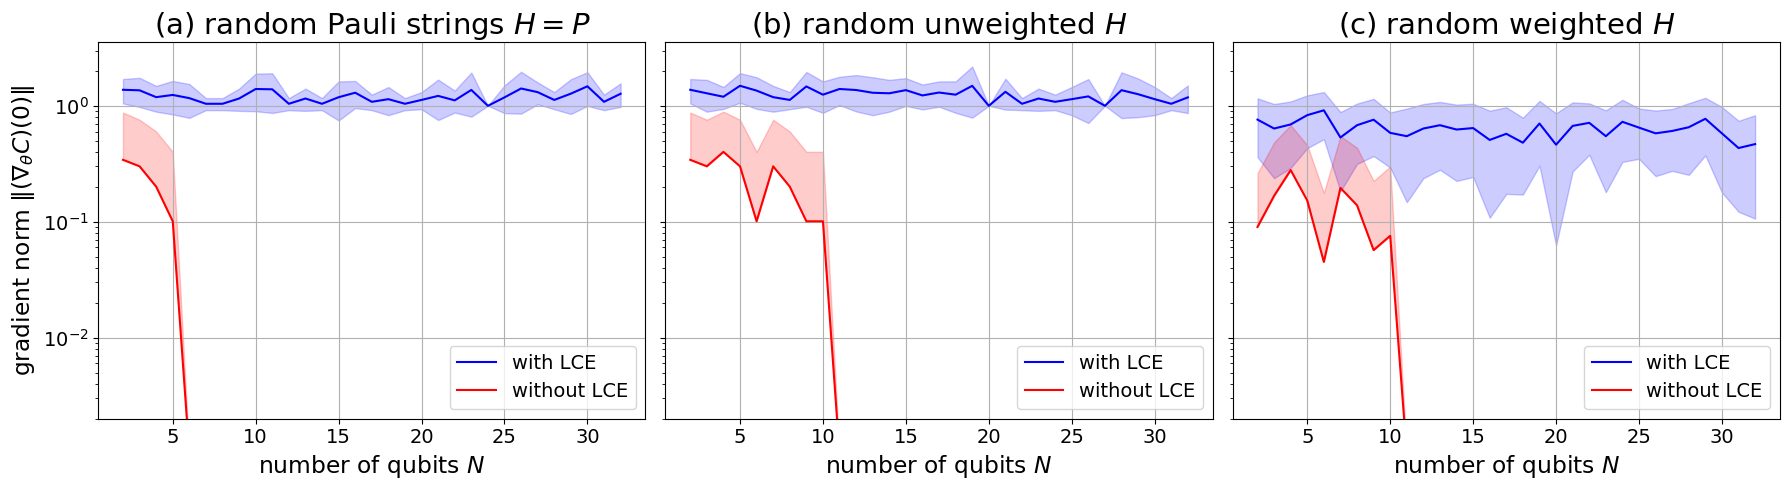

In [25]:
### Plotting the Results of EXPERIMENT IV_shallow:

font_size = 14
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- (a): mHEA ---
with open("data3_shallow.pkl", "rb") as f:
    data = pickle.load(f)
N = data["N_values"]
g = np.array(data["gradient_norms_zero_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.std(g, 1), np.std(g0, 1)
ax = axes[0]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title(r"(a) random Pauli strings $H=P$", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.set_ylabel(r'gradient norm $\|(\nabla_\theta C)(0)\|$', fontsize=1.2*font_size)
ax.set_yscale('log')
ax.grid(True)
ax.tick_params(labelsize=font_size)

# --- (b): random unweighted H ---
with open("data4_shallow.pkl", "rb") as f:
    data = pickle.load(f)
N = data["N_values"]
g = np.array(data["gradient_norms_zero_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.std(g, 1), np.std(g0, 1)
ax = axes[1]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title(r"(b) random unweighted $H$", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)
ax.set_yscale('log')

# --- (c): random weighted H ---
g = np.array(data["gradient_norms_zero2_data"]) + 1e-3
g0 = np.array(data["gradient_norms_zero2_data_noLCE"]) + 1e-3
m, m0 = np.mean(g, 1), np.mean(g0, 1)
s, s0 = np.minimum(np.std(g, 1), 0.4), np.std(g0, 1)
ax = axes[2]
ax.plot(N, m, label="with LCE", color='b')
ax.plot(N, m0, label="without LCE", color='r')
ax.fill_between(N, m - s, m + s, color='b', alpha=0.2)
ax.fill_between(N, m0, m0 + s0, color='r', alpha=0.2)
ax.set_title(r"(c) random weighted $H$", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)
ax.set_yscale('log')

axes[0].legend(fontsize=font_size)
axes[1].legend(fontsize=font_size)
axes[2].legend(fontsize=font_size)
#plt.suptitle("mHEA", fontsize=font_size * 1.8)

# ---- Uniform Y-axis range across all subplots
y_mins = [ax.get_ylim()[0] for ax in axes]
y_maxs = [ax.get_ylim()[1] for ax in axes]
y_min, y_max = min(y_mins), max(y_maxs) * 1.1
for ax in axes:
    ax.set_ylim(1/5*1e-2, y_max)

plt.tight_layout()
plt.savefig("benchmarking-zero-gradient-norm-shallow.pdf", format="pdf")
plt.show()


# Effective Complexity Experiments

In [8]:
### Experiment V: Effective Complexity of the Taylor Surrogate

# model parameters
N = 2
L_max = 5
m_max = 3

L_values = range(1, L_max + 1)

cardinalities = []
Taylor_coefficients_noLCE = []
Taylor_coefficients_LCE = []

norms_noLCE = []
norms_LCE = []
supports_noLCE = []
supports_LCE = []

for L in L_values:
    # generate circuit
    unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA
    D = unbound_circuit_noLCE.num_parameters # number of bindable VQU parameters

    # generate random pauli observable
    #random.seed(7)
    #pauli_string = RandomPauliString(N)
    pauli_string = N * 'Z'

    # modify the PQC with the Linear Clifford Encoder (LCE)
    random.seed(7)
    unbound_circuit_LCE = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1))

    # compute the truncated Taylor coefficients
    cardinality = 0 # for computing the cardinality of \mathcal{A}_m
    for alpha in generate_combinations(D, m_max):

        coeff_noLCE, _ = TaylorCoefficient(alpha, unbound_circuit_noLCE, pauli_string, np.zeros(D))
        coeff_LCE, _ = TaylorCoefficient(alpha, unbound_circuit_LCE, pauli_string, np.zeros(D))
        Taylor_coefficients_LCE.append(coeff_LCE)
        Taylor_coefficients_noLCE.append(coeff_noLCE)
        cardinality += 1
    
    cardinalities.append(cardinality)

    norm_noLCE = np.linalg.norm(np.array(Taylor_coefficients_noLCE))
    norm_LCE = np.linalg.norm(np.array(Taylor_coefficients_LCE))
    support_noLCE = np.count_nonzero(np.array(Taylor_coefficients_noLCE))
    support_LCE = np.count_nonzero(np.array(Taylor_coefficients_LCE))

    norms_noLCE.append(norm_noLCE)
    norms_LCE.append(norm_LCE)
    supports_noLCE.append(support_noLCE)
    supports_LCE.append(support_LCE)

    print('L:', L)

# store data in a dictionary
data5 = {
    "L_values": L_values,
    "cardinalities": cardinalities,
    "norms_noLCE": norms_noLCE,
    "norms_LCE": norms_LCE,
    "supports_noLCE": supports_noLCE,
    "supports_LCE": supports_LCE,
}

# save data
with open("data5.pkl", "wb") as f:
    pickle.dump(data5, f)

L: 1
L: 2
L: 3
L: 4
L: 5


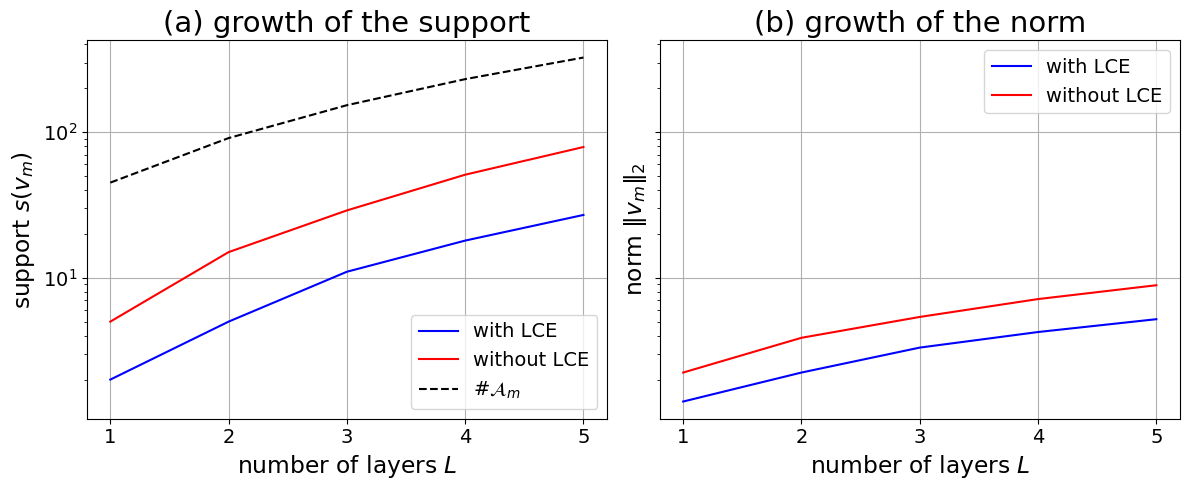

In [9]:
### Plotting the Results of EXPERIMENT V

font_size = 14
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# load data
with open("data5.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
L_values = data["L_values"]
cardinalities = data["cardinalities"]
norms_noLCE = data["norms_noLCE"]
norms_LCE = data["norms_LCE"]
supports_noLCE = data["supports_noLCE"]
supports_LCE = data["supports_LCE"]

# --- (a): support plot ---
ax = axes[0]
ax.plot(L_values, supports_LCE, label="with LCE", color='b')
ax.plot(L_values, supports_noLCE, label="without LCE", color='r')
ax.plot(L_values, cardinalities, label=r"$\#\mathcal{A}_m$", color='black', linestyle='--')
ax.set_title(r"(a) growth of the support", fontsize=1.5*font_size)
ax.set_xlabel(r'number of layers $L$', fontsize=1.2*font_size)
ax.set_ylabel(r'support $s(v_m)$', fontsize=1.2*font_size)
ax.set_yscale('log')
ax.grid(True)
ax.tick_params(labelsize=font_size)

# --- (b): norm plot ---<
ax = axes[1]
ax.plot(L_values, norms_LCE, label="with LCE", color='b')
ax.plot(L_values, norms_noLCE, label="without LCE", color='r')
ax.set_title(r"(b) growth of the norm", fontsize=1.5*font_size)
ax.set_xlabel(r'number of layers $L$', fontsize=1.2*font_size)
ax.set_ylabel(r'norm $\|v_m\|_2$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)
ax.set_yscale('log')

axes[0].legend(fontsize=font_size)
axes[1].legend(fontsize=font_size)

plt.tight_layout()
plt.savefig("taylor-support-scaling.pdf", format="pdf")
plt.show()

In [24]:
### Experiment Vb: Effective Complexity of the Taylor Surrogate

# model parameters
L = 1
N_max = 16
m_max = 3

N_values = range(1, N_max + 1)

cardinalities = []
Taylor_coefficients_noLCE = []
Taylor_coefficients_LCE = []

norms_noLCE = []
norms_LCE = []
supports_noLCE = []
supports_LCE = []

for N in N_values:
    # generate circuit
    unbound_circuit_noLCE = EfficientSU2(N, su2_gates=['ry', 'rz'], entanglement='circular', reps=L, flatten=True) # mHEA
    D = unbound_circuit_noLCE.num_parameters # number of bindable VQU parameters

    # generate random pauli observable
    #random.seed(7)
    #pauli_string = RandomPauliString(N)
    pauli_string = N * 'Z'

    # modify the PQC with the Linear Clifford Encoder (LCE)
    random.seed(7)
    unbound_circuit_LCE = LinearCliffordEncoder(unbound_circuit_noLCE, pauli_string, random.randint(0, D-1))

    # compute the truncated Taylor coefficients
    cardinality = 0 # for computing the cardinality of \mathcal{A}_m
    for alpha in generate_combinations(D, m_max):

        coeff_noLCE, _ = TaylorCoefficient(alpha, unbound_circuit_noLCE, pauli_string, np.zeros(D))
        coeff_LCE, _ = TaylorCoefficient(alpha, unbound_circuit_LCE, pauli_string, np.zeros(D))
        Taylor_coefficients_LCE.append(coeff_LCE)
        Taylor_coefficients_noLCE.append(coeff_noLCE)
        cardinality += 1
    
    cardinalities.append(cardinality)

    norm_noLCE = np.linalg.norm(np.array(Taylor_coefficients_noLCE))
    norm_LCE = np.linalg.norm(np.array(Taylor_coefficients_LCE))
    support_noLCE = np.count_nonzero(np.array(Taylor_coefficients_noLCE))
    support_LCE = np.count_nonzero(np.array(Taylor_coefficients_LCE))

    norms_noLCE.append(norm_noLCE)
    norms_LCE.append(norm_LCE)
    supports_noLCE.append(support_noLCE)
    supports_LCE.append(support_LCE)

    print('N:', N)

# store data in a dictionary
data5b = {
    "N_values": N_values,
    "cardinalities": cardinalities,
    "norms_noLCE": norms_noLCE,
    "norms_LCE": norms_LCE,
    "supports_noLCE": supports_noLCE,
    "supports_LCE": supports_LCE,
}

# save data
with open("data5b.pkl", "wb") as f:
    pickle.dump(data5b, f)

N: 1
N: 2
N: 3
N: 4
N: 5
N: 6
N: 7
N: 8
N: 9
N: 10
N: 11
N: 12
N: 13
N: 14
N: 15
N: 16


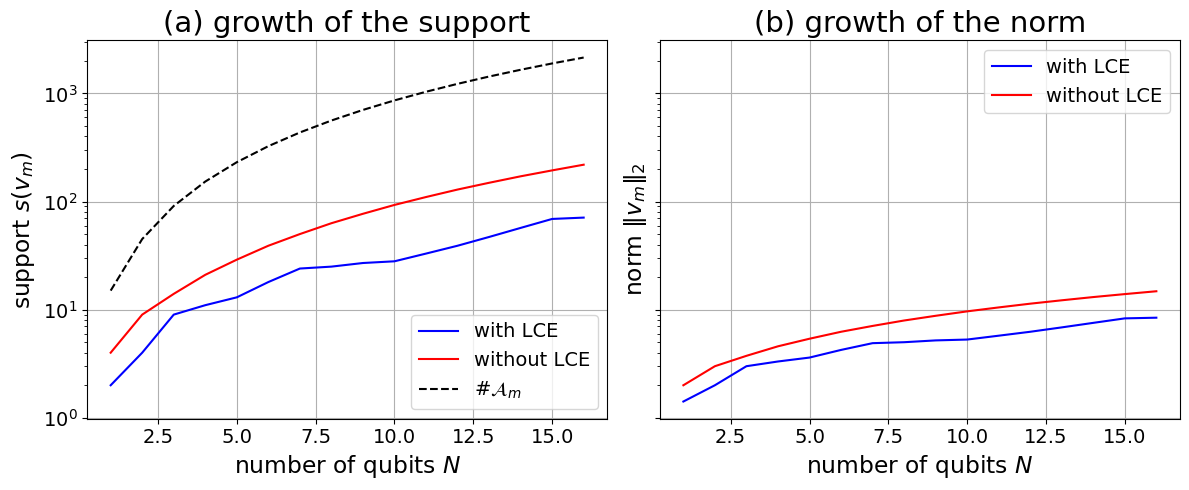

In [25]:
### Plotting the Results of EXPERIMENT Vb

font_size = 14
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# load data
with open("data5b.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
N_values = data["N_values"]
cardinalities = data["cardinalities"]
norms_noLCE = data["norms_noLCE"]
norms_LCE = data["norms_LCE"]
supports_noLCE = data["supports_noLCE"]
supports_LCE = data["supports_LCE"]

# --- (a): support plot ---
ax = axes[0]
ax.plot(N_values, supports_LCE, label="with LCE", color='b')
ax.plot(N_values, supports_noLCE, label="without LCE", color='r')
ax.plot(N_values, cardinalities, label=r"$\#\mathcal{A}_m$", color='black', linestyle='--')
ax.set_title(r"(a) growth of the support", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.set_ylabel(r'support $s(v_m)$', fontsize=1.2*font_size)
ax.set_yscale('log')
ax.grid(True)
ax.tick_params(labelsize=font_size)

# --- (b): norm plot ---<
ax = axes[1]
ax.plot(N_values, norms_LCE, label="with LCE", color='b')
ax.plot(N_values, norms_noLCE, label="without LCE", color='r')
ax.set_title(r"(b) growth of the norm", fontsize=1.5*font_size)
ax.set_xlabel(r'number of qubits $N$', fontsize=1.2*font_size)
ax.set_ylabel(r'norm $\|v_m\|_2$', fontsize=1.2*font_size)
ax.grid(True)
ax.tick_params(labelsize=font_size)
ax.set_yscale('log')

axes[0].legend(fontsize=font_size)
axes[1].legend(fontsize=font_size)

plt.tight_layout()
plt.savefig("taylor-support-scaling_qubits.pdf", format="pdf")
plt.show()